In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [3]:
filepath_train = '../Data/dichalcogenides_public/'
filepath_test = '../Data/dichalcogenides_private/'

targets = pd.read_csv(filepath_train + 'targets.csv', index_col=0)
targets.sort_index(inplace=True)
train_files = os.listdir(filepath_train + 'images/')
test_files = os.listdir(filepath_test + 'images/')

In [84]:
from sklearn.model_selection import train_test_split

train_matrix = pd.read_csv(filepath_train + 'Train_distance_matrix.csv', index_col=0)

idx_train, idx_val, y_train, y_val = train_test_split(train_matrix.columns, targets,
                                                      test_size=0.25, random_state=400)


X_train = train_matrix.loc[idx_train][idx_train]
X_val = train_matrix.loc[idx_train][idx_val]

test_matrix = pd.read_csv(filepath_test + 'Test_distance_matrix.csv', index_col=0)

In [85]:
predict = []
k = 100
for file in tqdm(idx_val):
    dist = X_val[file]
    dist[dist==0] = 1000
    dist = dist.sort_values()
    neighs = dist[:k].index
    x = targets.loc[neighs].band_gap
    x = sorted(x)
    for i in range(len(x)-1):
        if x[i+1] - x[i]  < 0.02:
            x[i+1] = x[i]
    x = pd.Series(x)
    predict.append(x.mode().max())
predictions = pd.DataFrame(data={'predictions': predict, 'id': idx_val})

  0%|          | 0/742 [00:00<?, ?it/s]

In [86]:
y = targets.loc[idx_val].copy()
y = y.reset_index()
y.columns = ['id', 'predictions']
ae = pd.DataFrame(np.abs(predictions.predictions - y.predictions))
ae.columns = ['abs_err']
ae.index = y.id
(ae < 0.02).sum() / len(predictions)

abs_err    0.660377
dtype: float64

In [73]:
wrong = np.array(ae.index[(ae>0.02).abs_err])

In [74]:
len(targets.loc[wrong].index[(targets.loc[wrong]<0.75).band_gap]) / len(wrong)

0.8666666666666667

In [38]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def plot_dist(idx):
    X  = train_matrix.loc[idx]
    IDs = train_matrix.columns
    Y = np.abs(targets.loc[IDs]- targets.loc[idx])
    X[X==1000] = 0
    plt.scatter(X.to_numpy(), Y.to_numpy(), s=0.8)
    abline(0, 0.02)
    plt.show()

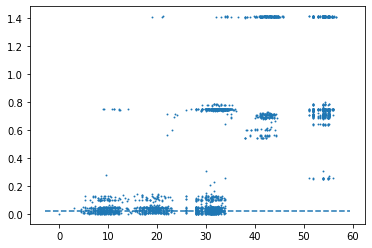

Target: 0.3994999999999999


In [43]:
i = 2
plot_dist(wrong[i])
print('Target:', targets.loc[wrong[i]].band_gap)

In [46]:
train_matrix.shape

(2966, 2966)

In [47]:
predict = []
k = 100
for file in tqdm(test_matrix.columns):
    dist = test_matrix[file]
    dist[dist==0] = 1000
    dist = dist.sort_values()
    neighs = dist[:k].index
    x = targets.loc[neighs].band_gap
    x = sorted(x)
    for i in range(len(x)-1):
        if x[i+1] - x[i]  < 0.02:
            x[i+1] = x[i]
    x = pd.Series(x)
    predict.append(x.mode().median())
predictions = pd.DataFrame(data={'predictions': predict, 'id': test_matrix.columns})
predictions.to_csv('submission.csv', index=False)

  0%|          | 0/2966 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [106]:
from sklearn.neighbors import KNeighborsRegressor

# X_test = test_matrix.loc[idx_train]

neigh = KNeighborsRegressor(n_neighbors=100, metric='precomputed')
neigh = neigh.fit(X_train.to_numpy(), y_train.to_numpy())

In [108]:
predictions = neigh.predict(np.transpose(X_val))
ae = np.abs(predictions - y_val)
(ae < 0.02).sum() / len(predictions)

band_gap    0.533693
dtype: float64